In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import math

In [2]:
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })

In [3]:
fsg.ls('data/PC-data')

['data/PC-data/bathym.nc',
 'data/PC-data/uv.nc',
 'data/PC-data/uvar.nc',
 'data/PC-data/vvar.nc']

In [4]:
data_path = 's3://data/PC-data/*.nc'


In [5]:
remote_files = fsg.glob(data_path)
remote_files

['data/PC-data/bathym.nc',
 'data/PC-data/uv.nc',
 'data/PC-data/uvar.nc',
 'data/PC-data/vvar.nc']

In [6]:
fileset = [fsg.open(file) for file in remote_files]

In [7]:
# This works
dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')

In [8]:
dset

<xarray.Dataset>
Dimensions:                        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth                          (depth) float32 0.5058 1.556 ... 5.902e+03
    time_centered                  object ...
    time_counter                   object ...
    nav_lat                        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon                        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    __xarray_dataarray_variable__  (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy                         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty                       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx                       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [9]:
dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
dset

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [10]:
# Smoothen data, over every tenth point in both x and y direction, for all the data
vvar = dset.vomecrty.rolling(y=10).mean()
uvar = dset.vozocrtx.rolling(x=10).mean()
uv = dset.vel.rolling(x=10).mean()
uv = uv.rolling(y=10).mean()

In [11]:
# List of x,y elements that I wanna plot over later 
dx = 20
dy = 20

In [12]:
# what is this for again? jmax,imax?
jmax, imax = uv[0].shape
i_list = np.arange(0,imax,dx)
j_list = np.arange(0,jmax,dy)

In [13]:
i_list.shape

(79,)

In [14]:
# Making the covmatrix and finding the eigenvalues and eigenvectors
# list of all the points for the PC-crosses
PC11 = np.zeros(3379)
PC12 = np.zeros(3379)
PC21 = np.zeros(3379)
PC22 = np.zeros(3379)
y = np.zeros(3379)
x = np.zeros(3379)
indx = 0


In [15]:
# to get the loop to run faster
uvy = np.array(uv.y.values)
uvx = np.array(uv.x.values)


In [16]:
# chooseing a level to look at 
level = 7
depth = dset.depth[level].values
print(depth)

9.82275


In [17]:
uvar0 = np.array(uvar[level,:,:].values)
vvar0 = np.array(vvar[level,:,:].values)
uvvel = np.array(uv[level,:,:].values)

In [18]:
for i in i_list:
    for j in j_list:
        covm = np.array([[uvar0[j,i],uvvel[j,i]],
        [uvvel[j,i],vvar0[j,i]]],dtype=float)
        if np.isnan(covm).any():
            continue
        else:
            values, vectors = np.linalg.eig(covm)
            PC11[int(indx)] = vectors[0,0]*np.sqrt(values[0])
            PC12[int(indx)] = vectors[1,0]*np.sqrt(values[0])
            PC21[int(indx)] = vectors[0,1]*np.sqrt(values[1])
            PC22[int(indx)] = vectors[1,1]*np.sqrt(values[1])
            y[int(indx)] = uvy[j]
            x[int(indx)] = uvx[i]
            indx = indx + 1

<ipython-input-18-b877499bb17d>:11: RuntimeWarning: invalid value encountered in sqrt
  PC21[int(indx)] = vectors[0,1]*np.sqrt(values[1])
<ipython-input-18-b877499bb17d>:12: RuntimeWarning: invalid value encountered in sqrt
  PC22[int(indx)] = vectors[1,1]*np.sqrt(values[1])
<ipython-input-18-b877499bb17d>:9: RuntimeWarning: invalid value encountered in sqrt
  PC11[int(indx)] = vectors[0,0]*np.sqrt(values[0])
<ipython-input-18-b877499bb17d>:10: RuntimeWarning: invalid value encountered in sqrt
  PC12[int(indx)] = vectors[1,0]*np.sqrt(values[0])


In [19]:
# converting to np.arrays
PC11 = np.array(PC11,dtype=float)
PC12 = np.array(PC12,dtype=float)
PC21 = np.array(PC21,dtype=float)
PC22 = np.array(PC22,dtype=float)
y = np.array(y,dtype=float)
x = np.array(x,dtype=float)

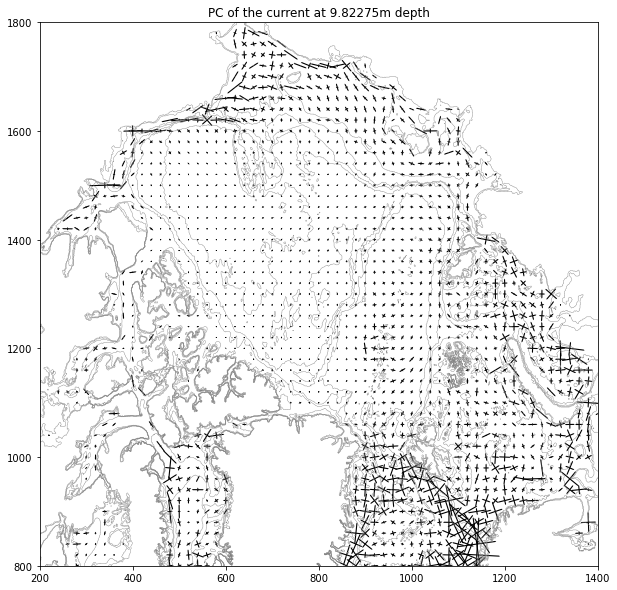

In [20]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.title(f'PC of the current at ' + str(depth) + 'm depth')
cmap = plt.get_cmap('magma_r')
ax.contour(dset.mbathy, colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::1], y[::1], PC11[::1], PC12[::1], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=4)
ax.quiver(x[::1], y[::1], -PC11[::1], -PC12[::1],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=4)
ax.quiver( x[::1], y[::1], PC21[::1], PC22[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=4)
ax.quiver( x[::1], y[::1], -PC21[::1], -PC22[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=4)
ax.set_xlim(200,1400)
ax.set_ylim(800,1800)

plt.show()